In [247]:
from __future__ import absolute_import, division, print_function
from matplotlib.font_manager import _rebuild; _rebuild()
import tensorflow as tf
import re
#Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io as spio
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from  sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import seaborn as sn
tf.logging.set_verbosity(tf.logging.INFO)

In [264]:
"""Load the dataset and set randomness."""

# Initialize random number generator for reproducibility.
seed = 7
np.random.seed(seed)

# Load in dataset.
data = spio.loadmat("features_10s_2019-01-30.mat");
features = data['features'];
labels = data['labels_features'];
animal_id_features = data['animal_id_features'].transpose();
print(data['label_names'])
feat_names = data['feat_names']
col_names = pd.DataFrame(feat_names) 
# Label each feature column with its description.
def find_between(s):
    start = '\'';
    end = '\'';
    return((s.split(start))[1].split(end)[0])
cols = [];
c_names = col_names.values.ravel();

for x in range(len(c_names)):
    name = str (c_names[x]);
    cols.append(find_between(name))
    
# Create a DataFrame of features with columns named & rows labeled.    
feat_data = pd.DataFrame(data=features,columns=cols)
feat_data.insert(0,'AnimalId',animal_id_features)
feat_data.insert(0,'Labels',labels.transpose())

# Select the features corresponding to one animal.
def get_single_animal_feats(df,index) : 
    return df.loc[df['AnimalId'] == index]

# TODO: Randomize!
# For now, we select the features of the first animal.
fKH41_features = get_single_animal_feats(feat_data, 1)

# Get only labels corresponding to first animal's features.
y = fKH41_features['Labels']
X = fKH41_features.drop(columns={'Labels','AnimalId'})

[[array(['Normal'], dtype='<U6') array(['Pre-ictal'], dtype='<U9')
  array(['Seizure'], dtype='<U7')]]


In [176]:
"""Split data into training and testing for cross-validation."""
X_train, X_test, y_train, y_test = train_test_split(X, y);

In [226]:
"""Standardize the data since the MLP is sensitive to feature scaling."""
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit only to the training data.
scaler.fit(X_train)
# Apply the transformations to the data.
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

"""Training the model!"""
mlp = MLPClassifier(max_iter=500,alpha=0.0001,
                     solver='sgd', verbose=10,  random_state=seed,tol=0.000000001)
y_score = mlp.fit(X_train,y_train)
y_pred = mlp.predict(X_test)

Iteration 1, loss = 0.65238248
Iteration 2, loss = 0.53469468
Iteration 3, loss = 0.50428631
Iteration 4, loss = 0.48398297
Iteration 5, loss = 0.46896964
Iteration 6, loss = 0.45769091
Iteration 7, loss = 0.44910852
Iteration 8, loss = 0.44239833
Iteration 9, loss = 0.43701004
Iteration 10, loss = 0.43239636
Iteration 11, loss = 0.42852534
Iteration 12, loss = 0.42506926
Iteration 13, loss = 0.42238582
Iteration 14, loss = 0.41955813
Iteration 15, loss = 0.41724503
Iteration 16, loss = 0.41513115
Iteration 17, loss = 0.41303644
Iteration 18, loss = 0.41125285
Iteration 19, loss = 0.40936414
Iteration 20, loss = 0.40777272
Iteration 21, loss = 0.40618895
Iteration 22, loss = 0.40456201
Iteration 23, loss = 0.40320290
Iteration 24, loss = 0.40202720
Iteration 25, loss = 0.40060158
Iteration 26, loss = 0.39958557
Iteration 27, loss = 0.39846092
Iteration 28, loss = 0.39740262
Iteration 29, loss = 0.39608374
Iteration 30, loss = 0.39526291
Iteration 31, loss = 0.39417891
Iteration 32, los

Iteration 253, loss = 0.31140206
Iteration 254, loss = 0.31103463
Iteration 255, loss = 0.31087914
Iteration 256, loss = 0.31082959
Iteration 257, loss = 0.31050645
Iteration 258, loss = 0.31024608
Iteration 259, loss = 0.31031676
Iteration 260, loss = 0.31001467
Iteration 261, loss = 0.30980455
Iteration 262, loss = 0.30979667
Iteration 263, loss = 0.30921717
Iteration 264, loss = 0.30963647
Iteration 265, loss = 0.30927620
Iteration 266, loss = 0.30894016
Iteration 267, loss = 0.30883603
Iteration 268, loss = 0.30841532
Iteration 269, loss = 0.30827121
Iteration 270, loss = 0.30794083
Iteration 271, loss = 0.30802635
Iteration 272, loss = 0.30783296
Iteration 273, loss = 0.30785578
Iteration 274, loss = 0.30764550
Iteration 275, loss = 0.30726846
Iteration 276, loss = 0.30730653
Iteration 277, loss = 0.30700014
Iteration 278, loss = 0.30679073
Iteration 279, loss = 0.30673257
Iteration 280, loss = 0.30654820
Iteration 281, loss = 0.30633670
Iteration 282, loss = 0.30595540
Iteration 

/anaconda3/envs/venv/lib/python3.5/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [249]:
"""Write a report detailing the performance metrics of the model.
Since our model is multiclass, we cannot run a binary AUC/ROC so have to compute
individual AUC/ROC one versus all values and average."""

def class_report(y_true, y_pred, y_score=None, average='micro'):
    if y_true.shape != y_pred.shape:
        print("Error! y_true %s is not the same shape as y_pred %s" % (
              y_true.shape,
              y_pred.shape)
        )
        return

    lb = LabelBinarizer()

    if len(y_true.shape) == 1:
        lb.fit(y_true)

    #Value counts of predictions
    labels, cnt = np.unique(
        y_pred,
        return_counts=True)
    n_classes = len(labels)
    pred_cnt = pd.Series(cnt, index=labels)

    metrics_summary = precision_recall_fscore_support(
            y_true=y_true,
            y_pred=y_pred,
            labels=labels)

    avg = list(precision_recall_fscore_support(
            y_true=y_true, 
            y_pred=y_pred,
            average='weighted'))

    metrics_sum_index = ['precision', 'recall', 'f1-score', 'support']
    class_report_df = pd.DataFrame(
        list(metrics_summary),
        index=metrics_sum_index,
        columns=labels)

    support = class_report_df.loc['support']
    total = support.sum() 
    class_report_df['avg / total'] = avg[:-1] + [total]

    class_report_df = class_report_df.T
    class_report_df['pred'] = pred_cnt
    class_report_df['pred'].iloc[-1] = total

    if not (y_score is None):
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for label_it, label in enumerate(labels):
            fpr[label], tpr[label], _ = roc_curve(
                (y_true == label).astype(int), 
                y_score[:, label_it])

            roc_auc[label] = auc(fpr[label], tpr[label])

        if average == 'micro':
            if n_classes <= 2:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                    lb.transform(y_true).ravel(), 
                    y_score[:, 1].ravel())
            else:
                fpr["avg / total"], tpr["avg / total"], _ = roc_curve(
                        lb.transform(y_true).ravel(), 
                        y_score.ravel())

            roc_auc["avg / total"] = auc(
                fpr["avg / total"], 
                tpr["avg / total"])

        elif average == 'macro':
            # First aggregate all false positive rates
            all_fpr = np.unique(np.concatenate([
                fpr[i] for i in labels]
            ))

            # Then interpolate all ROC curves at this points
            mean_tpr = np.zeros_like(all_fpr)
            for i in labels:
                mean_tpr += interp(all_fpr, fpr[i], tpr[i])

            # Finally average it and compute AUC
            mean_tpr /= n_classes

            fpr["macro"] = all_fpr
            tpr["macro"] = mean_tpr

            roc_auc["avg / total"] = auc(fpr["macro"], tpr["macro"])

        class_report_df['AUC'] = pd.Series(roc_auc)

    return class_report_df

"""Evaluate model performance."""
accuracy_score(y_test, y_pred)

report_w_auc = class_report(y_test,y_pred,mlp.predict_proba(X_test))
print(report_w_auc)

[[11224  1507     0]
 [ 1964  9312    18]
 [    1    47    94]]
             precision    recall  f1-score  support     pred       AUC
0             0.851012  0.881628  0.866049  12731.0  13189.0  0.928424
1             0.856985  0.824509  0.840433  11294.0  10866.0  0.925739
2             0.839286  0.661972  0.740157    142.0    112.0  0.991013
avg / total   0.853735  0.853643  0.853338  24167.0  24167.0  0.963220


Text(0.5, 1.0, '% Correct Label by Class')

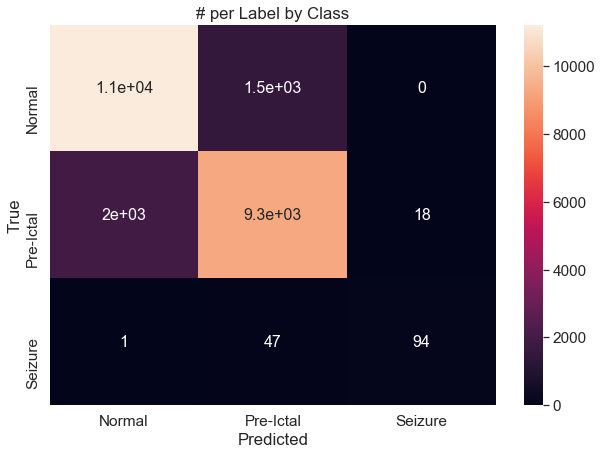

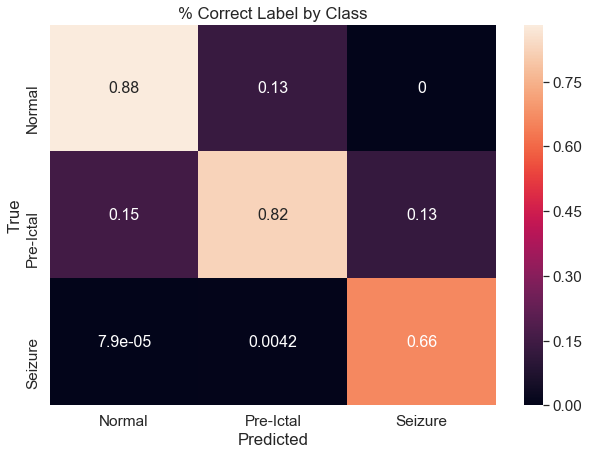

In [271]:
"""A confusion matrix shows C{i,j}, 
the number of predictions known to be in group i 
but predicted to be in group j."""
cm = confusion_matrix(y_test, y_pred)

float_formatter = lambda x: "%.2f" % x
np.set_printoptions(formatter={'float_kind':float_formatter})
np.set_printoptions(precision=2)
# Plot raw confusion matrix.
df_cm = pd.DataFrame(cm, index = ["Normal","Pre-Ictal","Seizure"], 
                         columns = ["Normal","Pre-Ictal","Seizure"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size":16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('# per Label by Class')


# Normalize confusion matrix.
cm = cm / (cm.astype(np.float).sum(axis=1))

# Plot the percentages of correct/incorrect label by class.
df_cm = pd.DataFrame(cm, index = ["Normal","Pre-Ictal","Seizure"], 
                         columns = ["Normal","Pre-Ictal","Seizure"])
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)
sn.heatmap(df_cm, annot=True,annot_kws={"size":16})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('% Correct Label by Class')

